### Global analysis (no marginalization)
This notebook analyses and plots the global results of mode1 and mode4 with no marginalization on graph properties.


The results are based on

-----------
OBS: Uncomment lines when mode4 is ready to be analysed. Feel free to add what you want

In [1]:
import pandas as pd
import json
from evaluation_utils import read_processed_shards, get_best_configuration_per_model
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
from matplotlib.ticker import PercentFormatter
from scipy.stats import f_oneway
from tqdm import tqdm
import pylab as pl
import matplotlib as mpl
from collections import OrderedDict
import itertools
%matplotlib inline

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


##### CONSTANTS
These constants are used to specify different views of our results which might be interesting

In [22]:
# --------- DATA ---------
MODE_1_PROCESSED_DIR = f'/home/data_shares/scara/graphworld/results/mode1/processed' # mode1
# MODE_1_PROCESSED_DIR = f'results/mode1/processed' # mode1
#MODE_4_PROCESSED_DIR = f'results/mode1/processed' # mode4

# --------- MODELS ---------
GENERATION_FEATURES = ['AttributeMask', 'CorruptedEmbeddingsReconstruction', 'CorruptedFeaturesReconstruction']
GENERATION_STRUCTURE = ['EdgeMask', 'GAE']
GENERATION_ALL = GENERATION_FEATURES + GENERATION_STRUCTURE
AUXILIARY_ALL = ['NodeClusteringWithAlignment', 'S2GRL', 'PairwiseAttrSim', 'GraphPartitioning']
CONTRAST_SAME_SCALE = ['BGRL', 'GBT', 'GCA', 'SelfGNNPPR', 'SelfGNNSplit', 'MERIT']
CONTRAST_CROSS_SCALE = ['DeepGraphInfomax', 'GraphInfoClust', 'SUBGCON']
CONTRAST_ALL = CONTRAST_SAME_SCALE + CONTRAST_CROSS_SCALE
HYBRID_ALL = ['G_Zoom', 'MEtAl', 'MVMI_FT']
ALL_MODELS = GENERATION_ALL + AUXILIARY_ALL + CONTRAST_ALL + HYBRID_ALL
N_MODELS = len(ALL_MODELS)

# --------- ENCODERS ---------
ENCODERS = ['GCN', 'GAT', 'GIN']

# --------- TRAINING SCHEMES ---------
TRAINING_SCHEMES = ['JL', 'PF', 'URL']

# --------- BASELINES ---------
BASELINES = ['GCN', 'GAT', 'GIN']

# --------- TEST METRIC ---------
TEST_METRIC = 'test_rocauc_ovr'

##### INDEXING
General scheme of a column: `Encoder_model_scheme`
Example of a column: `GCN_AttributeMask_JL`

##### READING DATA
We read the data and remove graphs where any model has failed / crashed

In [3]:
# --------- READING DATA ---------
df1 = read_processed_shards(MODE_1_PROCESSED_DIR) # mode1
df1.drop(['marginal_param', 'fixed_params'], axis=1, inplace=True)
df1.dropna(axis=0, inplace=True)

#df4 = read_processed_shards(PROCESSED_DIR_4) # mode4
#df4.drop(['marginal_param', 'fixed_params'], axis=1, inplace=True)
#df4.dropna(axis=0, inplace=True)

1.ndjson
2.ndjson
3.ndjson
4.ndjson
5.ndjson
6.ndjson
7.ndjson
8.ndjson
9.ndjson
10.ndjson
11.ndjson
concatenating


##### Global distribution results

Below we plot the distribution of test results for each of the baseline and SSL methods and training schemes.



In [4]:
df1['GCN_MVMI_FT_JL_train_pretext_weight']

0        500
1          5
4        500
5          1
6         10
        ... 
99995     10
99996    100
99997     10
99998     50
99999    100
Name: GCN_MVMI_FT_JL_train_pretext_weight, Length: 97943, dtype: int64

In [20]:
[f for f in df1.columns if 'GCN__' in f]

['GCN__JL_val_accuracy',
 'GCN__JL_val_f1_micro',
 'GCN__JL_val_f1_macro',
 'GCN__JL_val_rocauc_ovr',
 'GCN__JL_val_rocauc_ovo',
 'GCN__JL_val_logloss',
 'GCN__JL_test_accuracy',
 'GCN__JL_test_f1_micro',
 'GCN__JL_test_f1_macro',
 'GCN__JL_test_rocauc_ovr',
 'GCN__JL_test_rocauc_ovo',
 'GCN__JL_test_logloss',
 'GCN__JL_train_downstream_epochs',
 'GCN__JL_train_downstream_lr',
 'GCN__JL_train_patience',
 'GCN__JL_train_pretext_weight',
 'GCN__JL_encoder_in_channels',
 'GCN__JL_encoder_hidden_channels',
 'GCN__JL_encoder_num_layers',
 'GCN__JL_encoder_dropout',
 'GCN__JL_encoder_out_channels',
 'GCN__JL_skipped']

In [42]:
def unpivot_ssl_model(df : pd.DataFrame, suffix : str, ssl_models = ALL_MODELS, encoders = ENCODERS, training_schemes = TRAINING_SCHEMES):
    frames = []
    for (ssl_model, encoder, scheme) in itertools.product(*[ssl_models, encoders, training_schemes]):
        column = f'{encoder}_{ssl_model}_{scheme}_{suffix}'
        pretext_weight_col = f'{encoder}_{ssl_model}_{scheme}_train_pretext_weight'
        if not column in df.columns:
            continue
        df_model = df[[column]].rename(columns=lambda col: col.replace(column, suffix))
        df_model['pretext_weight'] = df[pretext_weight_col] if pretext_weight_col in df.columns else None    
        df_model['SSL_model'] = ssl_model
        df_model['Encoder'] = encoder
        df_model['Training_scheme'] = scheme
        df_model['Graph_ID'] = df.index.values.tolist()

        frames += [df_model]
    return pd.concat(frames, ignore_index=True)

def unpivot_bvaseline_model(df : pd.DataFrame, suffix : str, baseline_models = BASELINES, training_schemes = TRAINING_SCHEMES):
    frames = []
    for baseline_model, training_scheme in itertools.product(*[baseline_models, training_schemes]):
        column = f'{baseline_model}__{training_scheme}_{suffix}'
        if not column in df.columns:
            continue
        df_model = df[[column]].rename(columns=lambda col: col.replace(column, suffix))
        df_model['Baseline_model'] = baseline_model
        df_model['Graph_ID'] = df.index.values.tolist()
        
        frames += [df_model]
    return pd.concat(frames, ignore_index=True)

In [43]:
df = unpivot_ssl_model(df1, TEST_METRIC)
df_baseline = unpivot_bvaseline_model(df1, TEST_METRIC)

For the baselines, GIN seems to perform best. GCN and GAT performs similar.

<AxesSubplot: xlabel='test_rocauc_ovr', ylabel='Density'>

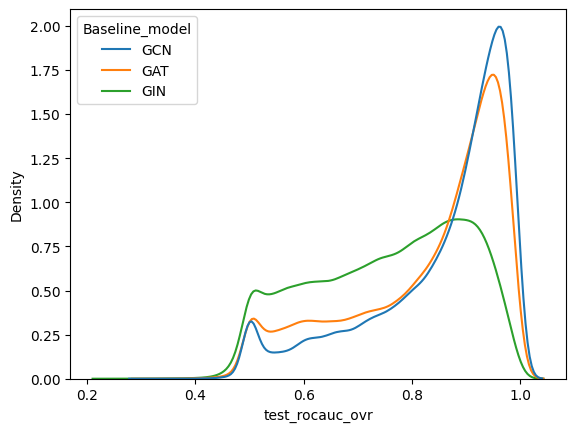

In [46]:
sns.kdeplot(data=df_baseline, x=TEST_METRIC, hue='Baseline_model')

Overall:
No big difference between GAT and GCN
Be careful with interpretation of the joint learning schemes. It can be in some cases the loss for one method is
just way higher than the other which impacts the learning. However, in two-stage training, the models have
time to change their parameters if the pretext task has found a bad set of parameters.

Investigate JL vs the two-stage trainings. It might show that when JL = 0.5, then two-stage is larger
because the pretext task might just have been bad.

GIN overall worse. Experiments in URL getting roc = 0.5 have many GIN in some cases.

MVMI_FT:

Overall good. Especially pretraining, finetuning.


MEtAl:
Joint learning has a lot of ROC=0.5. URL and PF actually seems to perform better.

G_zoom:
Very stable across the three learning schemes. JL seems to have a bit more ROC=0.5.

SUBGCON:
Also very stable across the three learning schemes. Does not seem to be influenced much here.

GraphInfoClust:
Joint learning is mostly impacted.

DeepGraphInfomax:
Also impacted by JL. PF seems to perform best

MERIT:
Does not seem to be impacted much by the learning scheme - very stable.

SelfGNNSplit:
JL and URL mostly impacted.

SelfGNNPPR:
Not impacted very much by learning scheme. Joint learning however seems to have more roc=0.5, followed by PF.

GCA:
JL Worse. much of the same as above

GBT:
Neither that much impacted by training scheme.

BGRL:
...

GraphPartitioning:
...

PairwiseAttrSim:
...

S2GRL:
...


NodeClusteringWithAlignment:
JL really good. However it is also the one with most roc=0.5 Either really good (roc=0.5) or really bad (roc=1)


GAE:
JL most roc=0.5

EdgeMask
...

CorrupedFeatureReconstruction:
Hard time on JL


CorruptedEmbeddingReconstruction:
Even harder time on JL than CorruptedFeatureReconstruction

AttributeMask:
Difficult on JL.

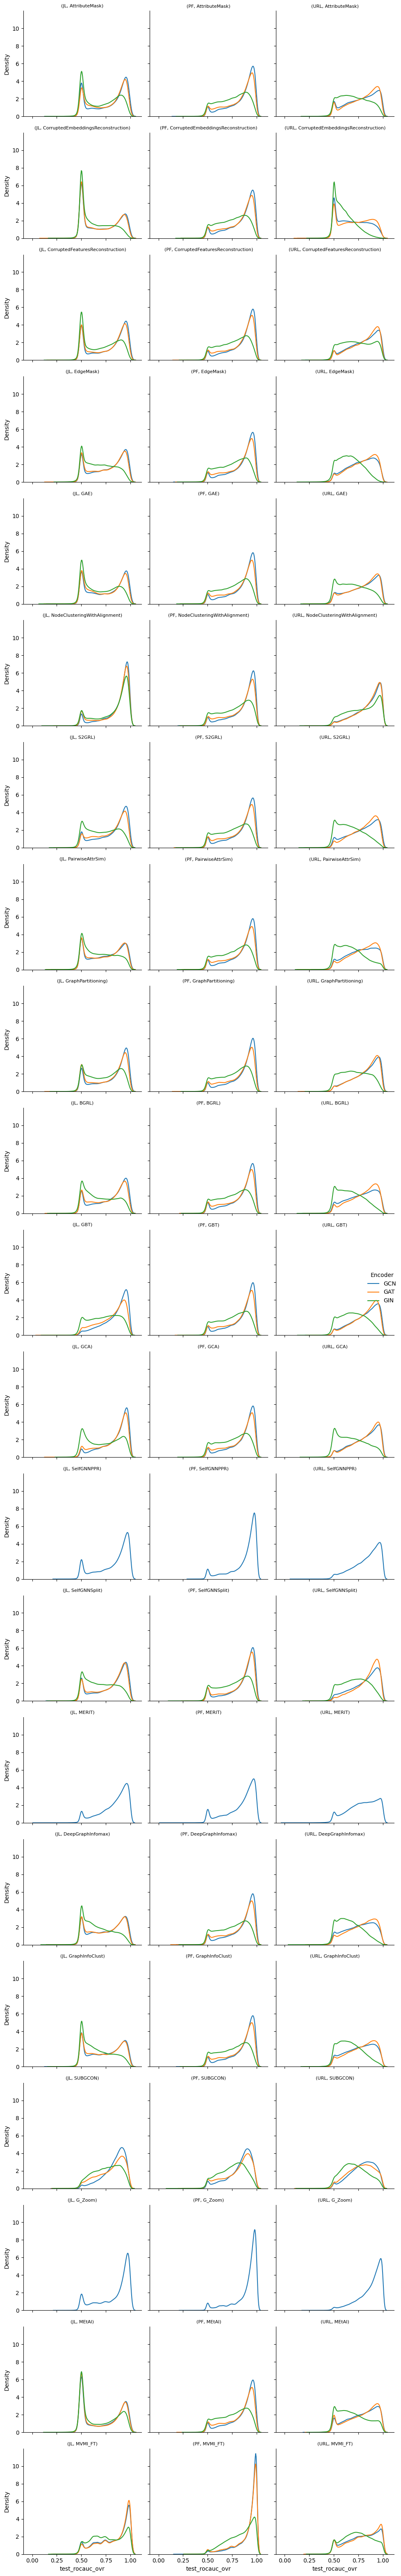

In [47]:
g = sns.FacetGrid(data=df, row='SSL_model', col='Training_scheme', hue='Encoder')
g.map(sns.kdeplot, TEST_METRIC)
g.set_titles(template="({col_name}, {row_name})", size=8)
g.add_legend()
plt.tight_layout()

##### Training scheme results

Below we plot the distribution of results for the three training schemes.

- Models trained with joint learning has a lot of samples which gets an ROC of 1/2 indicating they do not learn anything.
- For 2-stage training setups, most models get a high ROC while few get a low ROC.


In [48]:
grp = df.groupby('Training_scheme')
N_bins = 30
results = []
for key, v in grp:
    bins = pd.cut(v[TEST_METRIC], bins=np.linspace(0, 1, N_bins + 1)).value_counts().reset_index().rename(columns={ 'index': 'ROC-AUC', 'test_rocauc_ovr': 'Fraction' })
    bins['Fraction'] = bins['Fraction'] / bins['Fraction'].sum()
    bins['Training_scheme'] = key
    bins['ROC-AUC'] = bins['ROC-AUC'].apply(lambda x: f'({x.left:.2f}, {x.right:.2f}]')
    results += [bins]
bin_df = pd.concat(results)

/home/daen/.conda/envs/scara/lib/python3.10/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


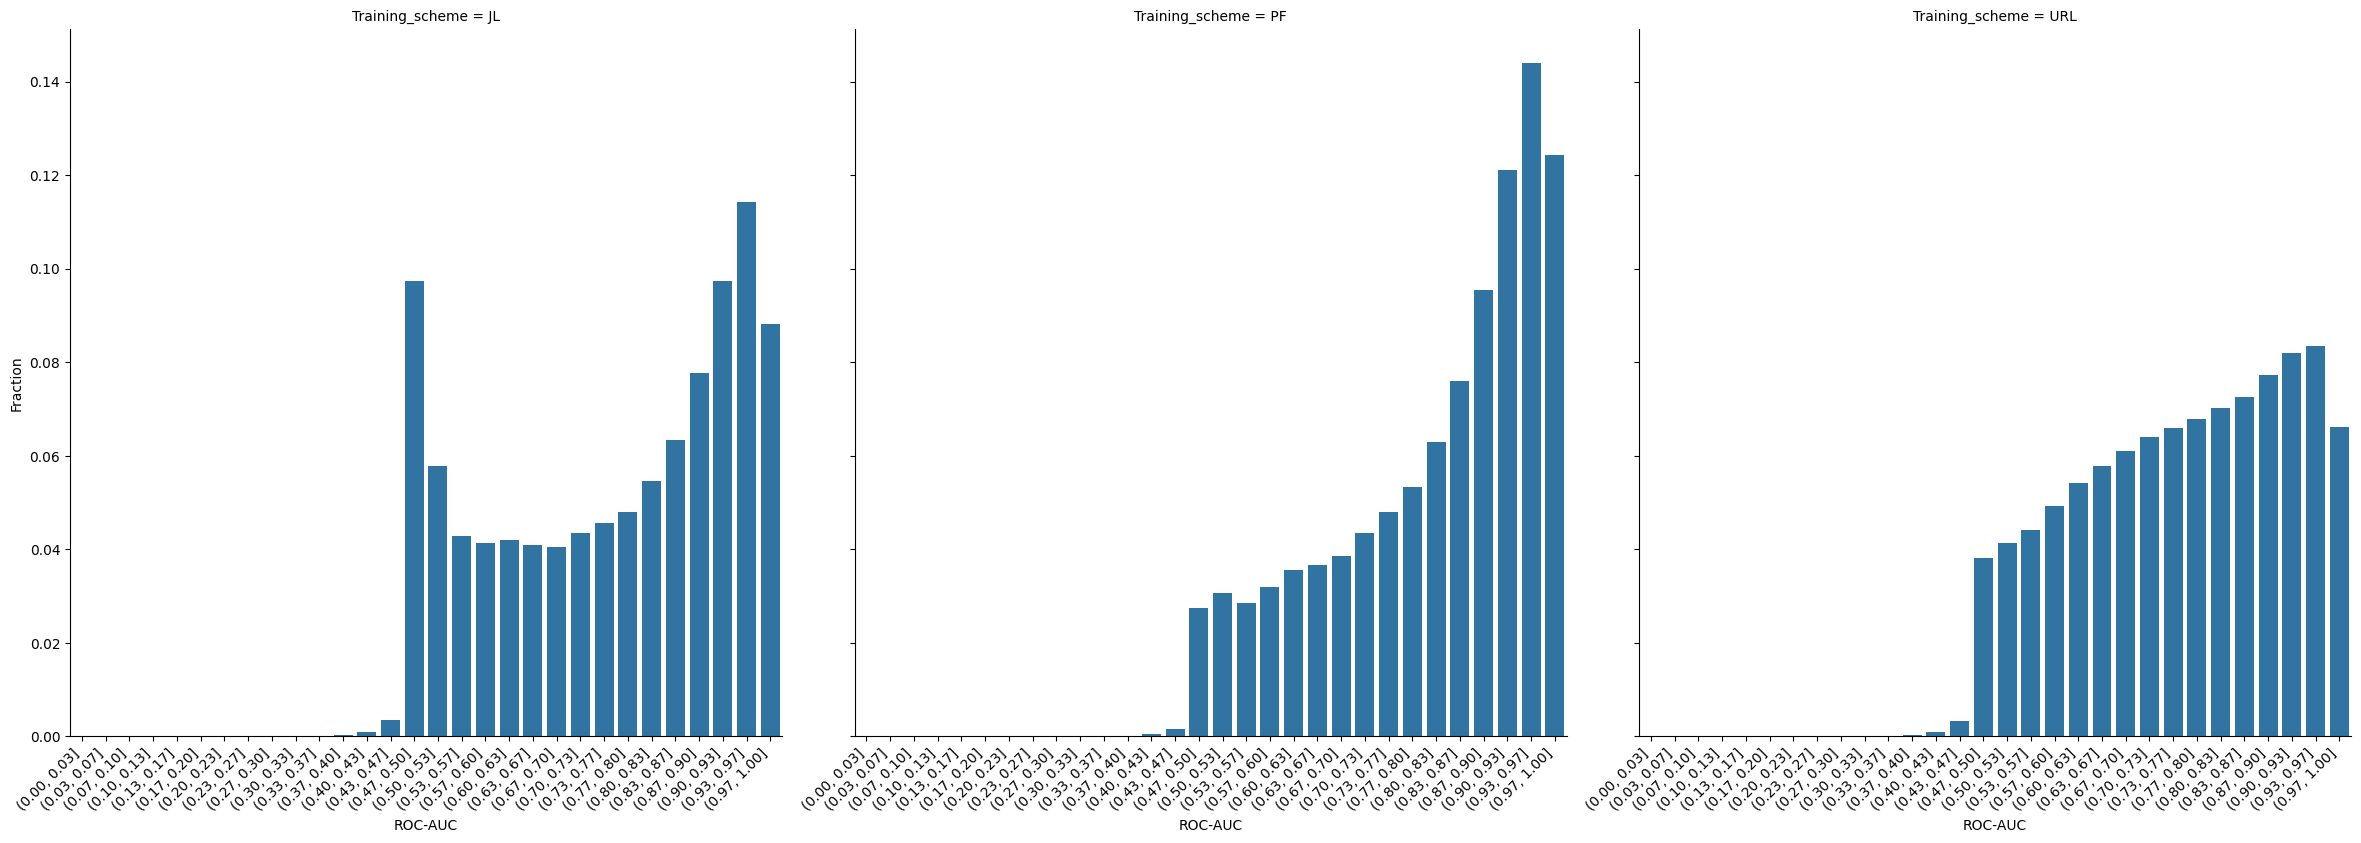

In [49]:
g = sns.FacetGrid(data=bin_df, col='Training_scheme', height=8, aspect=1)
g.map(sns.barplot, 'ROC-AUC', 'Fraction')
plt.tight_layout()
for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

##### Pretext weight

One could easily think the high pretext weight is what causes the joint learning to perform bad. We therefore group all results by the pretext weight and bin the ROC score. We visualize the results as a line plot to see how the ROC score varies given the different bins.

Here we see the lower the pretext weight the higher the ROC score and vice versa.

In [50]:
JL = df[~df.pretext_weight.isna()]
N_bins = 30
results =[]
bin_edges = np.around(np.linspace(0, 1, N_bins + 1),2)
for key, v in JL.groupby('pretext_weight'):
    bins = pd.cut(v[TEST_METRIC], bins=bin_edges).value_counts().reset_index().rename(columns={ 'index': 'ROC-AUC', 'test_rocauc_ovr': 'Fraction' })
    bins['Fraction'] = bins['Fraction'] / bins['Fraction'].sum()
    bins['pretext_weight'] = key
    results += [bins]
bin_df = pd.concat(results)

/tmp/ipykernel_29443/768499500.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')


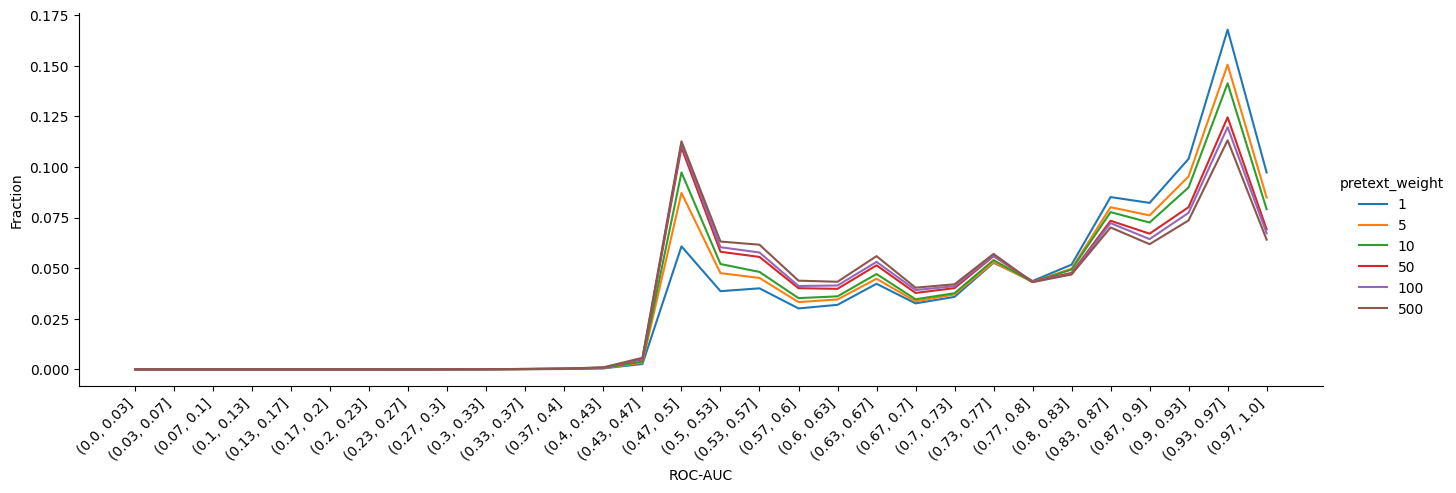

In [51]:
bins_copied = bin_df.copy()
bins_copied['ROC-AUC'] = bins_copied['ROC-AUC'].apply(lambda x: f'({x.left}, {x.right}]')
g = sns.FacetGrid(data=bins_copied, hue='pretext_weight', height=4.5, aspect=3)
g.map(sns.lineplot, 'ROC-AUC', 'Fraction')
for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
g.add_legend()

In [52]:
most_observations = bin_df.groupby('ROC-AUC').Fraction.sum().idxmax()
df_JL = df[df.Training_scheme == 'JL']
df_JL['ROC-AUC-bin'] = pd.cut(df_JL[TEST_METRIC], bins=bin_edges)
df_JL = df_JL[df_JL['ROC-AUC-bin'] == most_observations]

df_JL_counts = df_JL.groupby('SSL_model').count().rename(columns={'ROC-AUC-bin': 'total_count'})[['total_count']]
df_JL_grouped = df_JL.groupby(['SSL_model', 'pretext_weight']).count().rename(columns={ 'ROC-AUC-bin': 'count'})[['count']]
df_JL_grouped_raw_counts = df_JL_grouped.copy().reset_index()
df_JL_grouped = df_JL_grouped.join(other=df_JL_counts, on='SSL_model')      # Add the total counts in each method
df_JL_grouped['count'] /= df_JL_grouped['total_count']                      # Normalize by total counts in each method.
df_JL_grouped = df_JL_grouped.reset_index()

/tmp/ipykernel_29443/4099461290.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_JL['ROC-AUC-bin'] = pd.cut(df_JL[TEST_METRIC], bins=bin_edges)


We now also condition on the SSL model. Here, we choose the ROC-AUC bin which has the highest frequency. In this case it is (0.93, 0.97]. We then see for the given bin, how much does the frequency vary between the pretext weight. This can indicate how many experiments with a specific pretext weight resulted in this ROC-AUC score which in this case is a good and high ROC-AUC score.

##### Most variance
- CorruptedEmbeddingReconstruction
- GraphInfoClust
- DeepGraphInfomax
- EdgeMask
- GraphInfoClust
- MVMI_FT
- PairwiseAttrSim
- SelfGNNSplit

##### Least variance
- AttributeMask
- CorruptedFeatureReconstruction
- GBT
- GCA
- G_Zoom
- MEtAl
- NodeClusteringWithAlignment

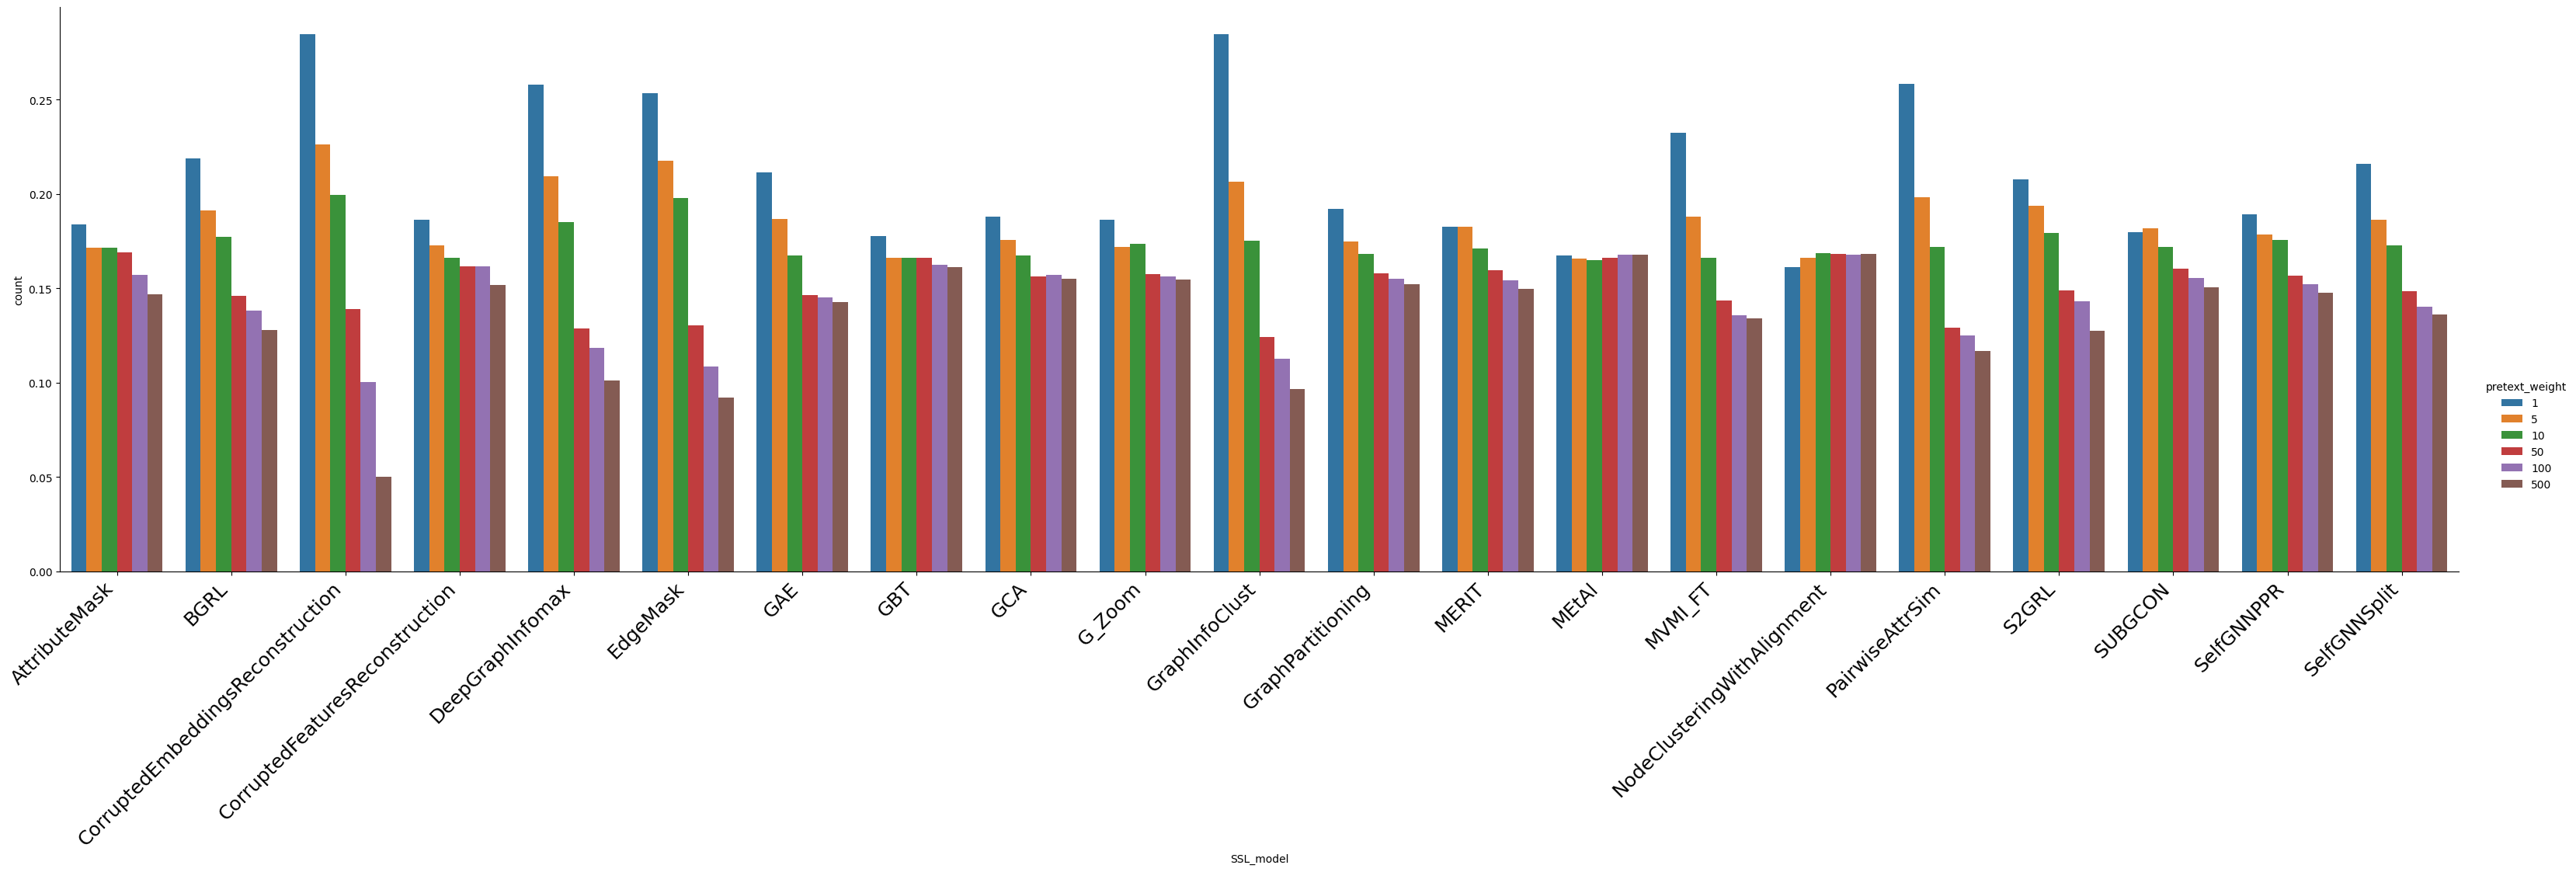

In [53]:
g = sns.catplot(
    data=df_JL_grouped,
    x='SSL_model',
    y='count',
    hue='pretext_weight',
    kind='bar',
    height=8,
    aspect=4.
)
g.set_xticklabels(rotation=45, horizontalalignment='right', fontsize=18)
g.set_titles(f'Fraction of experiments for each SSL method for bin {most_observations}')

We also plot the total amount of experiments in each of the bins given the pretext weight. Here CorruptedEmbbedingReconstruction is the method with the fewest experiments (~1k) for a pretext weight of 500. Also, the higher the pretext weight the less evidence.

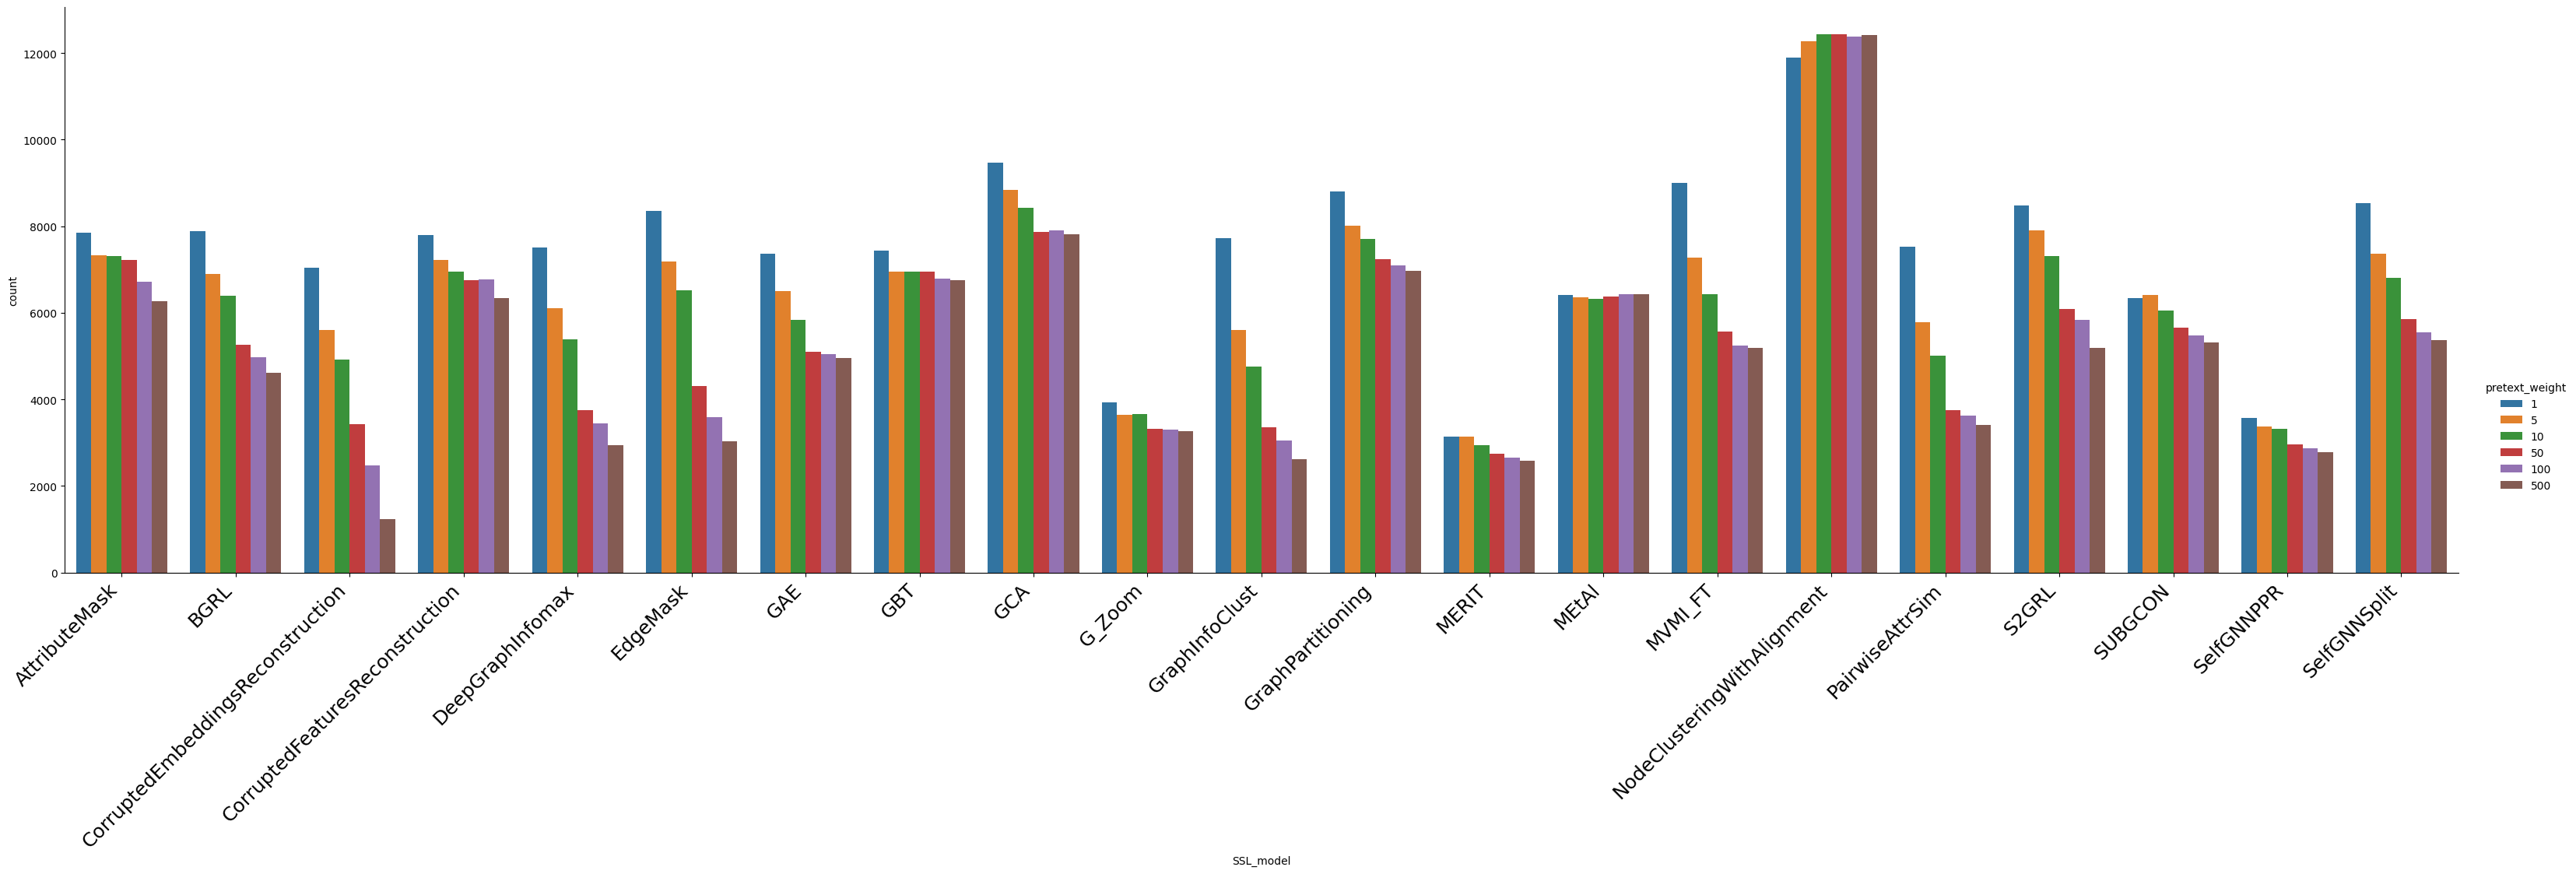

In [54]:
g = sns.catplot(
    data=df_JL_grouped_raw_counts,
    x='SSL_model',
    y='count',
    hue='pretext_weight',
    kind='bar',
    height=8,
    aspect=4.
)
g.set_xticklabels(rotation=45, horizontalalignment='right', fontsize=18)
g.set_titles(f'Total number of experiments')

##### Mean and std global results for all models
Here we report the mean and std test metric of all models per main category:
- Generation-based
- Auxiliary-based
- Contrast-based
- Hybrid


In [ ]:
def get_performance_summary_for_models(df, MODELS, ENCODERS = ENCODERS, TRAINING_SCHEMES = TRAINING_SCHEMES):
    results = []
    for model in MODELS:
        data = [model]
        for e in ENCODERS:
            for ts in TRAINING_SCHEMES:
                model_string = f'{e}_{model}_{ts}_{TEST_METRIC}'
                if not model_string in df.columns:
                    continue
                metric = df[f'{e}_{model}_{ts}_{TEST_METRIC}']
                avg = metric.mean()
                std = metric.std()
                data.append(f'{round(avg, 2)}\u00B1{round(std,2)}')
        results.append(data)

    result_cols = ['model'] + [f'{encoder}-{ts}' for encoder in ENCODERS for ts in TRAINING_SCHEMES]
    return pd.DataFrame(results, columns=result_cols)

In [ ]:
generation_df = get_performance_summary_for_models(df1, GENERATION_ALL)

,model,GCN-JL,GCN-PF,GCN-URL,GAT-JL,GAT-PF,GAT-URL,GIN-JL,GIN-PF,GIN-URL
0,AttributeMask,0.78±0.18,0.85±0.14,0.78±0.15,0.77±0.17,0.82±0.14,0.79±0.14,0.71±0.17,0.76±0.14,0.71±0.14
1,CorruptedEmbeddingsReconstruction,0.71±0.18,0.84±0.14,0.69±0.15,0.7±0.18,0.82±0.14,0.72±0.15,0.64±0.15,0.75±0.14,0.61±0.1
2,CorruptedFeaturesReconstruction,0.79±0.18,0.85±0.14,0.8±0.14,0.77±0.18,0.83±0.14,0.81±0.14,0.7±0.17,0.76±0.14,0.74±0.15
3,EdgeMask,0.78±0.17,0.85±0.14,0.77±0.14,0.76±0.17,0.82±0.14,0.79±0.13,0.69±0.15,0.75±0.14,0.67±0.12
4,GAE,0.76±0.18,0.85±0.14,0.79±0.15,0.74±0.18,0.82±0.15,0.79±0.14,0.69±0.16,0.76±0.14,0.7±0.14


In [ ]:
auxiliary_df = get_performance_summary_for_models(df1, AUXILIARY_ALL)  

,model,GCN-JL,GCN-PF,GCN-URL,GAT-JL,GAT-PF,GAT-URL,GIN-JL,GIN-PF,GIN-URL
0,NodeClusteringWithAlignment,0.87±0.14,0.86±0.13,0.84±0.13,0.85±0.15,0.83±0.14,0.85±0.13,0.83±0.16,0.77±0.15,0.79±0.15
1,S2GRL,0.82±0.15,0.85±0.14,0.79±0.14,0.8±0.15,0.82±0.14,0.8±0.13,0.71±0.15,0.75±0.14,0.67±0.13
2,PairwiseAttrSim,0.75±0.17,0.85±0.14,0.77±0.14,0.75±0.17,0.82±0.14,0.79±0.14,0.69±0.15,0.76±0.14,0.68±0.13
3,GraphPartitioning,0.81±0.17,0.85±0.13,0.82±0.13,0.78±0.17,0.82±0.14,0.82±0.13,0.73±0.16,0.76±0.14,0.71±0.14


In [ ]:
contrast_df = get_performance_summary_for_models(df1, CONTRAST_ALL)

,model,GCN-JL,GCN-PF,GCN-URL,GAT-JL,GAT-PF,GAT-URL,GIN-JL,GIN-PF,GIN-URL
0,BGRL,0.79±0.16,0.85±0.14,0.77±0.14,0.77±0.16,0.82±0.15,0.8±0.14,0.69±0.15,0.75±0.14,0.67±0.13
1,GBT,0.84±0.13,0.85±0.13,0.81±0.13,0.81±0.14,0.83±0.14,0.81±0.13,0.73±0.14,0.76±0.14,0.7±0.13
2,GCA,0.84±0.14,0.85±0.14,0.81±0.14,0.82±0.15,0.83±0.14,0.82±0.13,0.72±0.16,0.75±0.14,0.69±0.14
3,SelfGNNPPR,0.83±0.16,0.88±0.13,0.83±0.13,None,None,None,None,None,None
4,SelfGNNSplit,0.8±0.16,0.85±0.14,0.81±0.14,0.79±0.16,0.83±0.14,0.84±0.12,0.69±0.15,0.76±0.15,0.72±0.13
5,MERIT,0.83±0.14,0.84±0.15,0.79±0.15,None,None,None,None,None,None
6,DeepGraphInfomax,0.76±0.17,0.85±0.14,0.76±0.14,0.75±0.16,0.82±0.14,0.78±0.14,0.67±0.14,0.75±0.14,0.67±0.12
7,GraphInfoClust,0.75±0.17,0.85±0.14,0.76±0.14,0.74±0.17,0.82±0.14,0.78±0.14,0.66±0.15,0.75±0.14,0.67±0.12
8,SUBGCON,0.84±0.11,0.83±0.12,0.79±0.12,0.8±0.13,0.81±0.14,0.77±0.13,0.76±0.13,0.75±0.13,0.71±0.13


In [43]:
hybrid_df = get_performance_summary_for_models(df1, HYBRID_ALL)

,model,GCN-JL,GCN-PF,GCN-URL,GAT-JL,GAT-PF,GAT-URL,GIN-JL,GIN-PF,GIN-URL
0,G_Zoom,0.84±0.16,0.89±0.13,0.87±0.12,None,None,None,None,None,None
1,MEtAl,0.73±0.19,0.85±0.14,0.78±0.15,0.72±0.19,0.83±0.14,0.79±0.15,0.69±0.18,0.76±0.14,0.7±0.14
2,MVMI_FT,0.82±0.16,0.91±0.11,0.78±0.15,0.83±0.15,0.9±0.12,0.8±0.15,0.77±0.16,0.83±0.13,0.74±0.14
